[*********************100%***********************]  1 of 1 completed


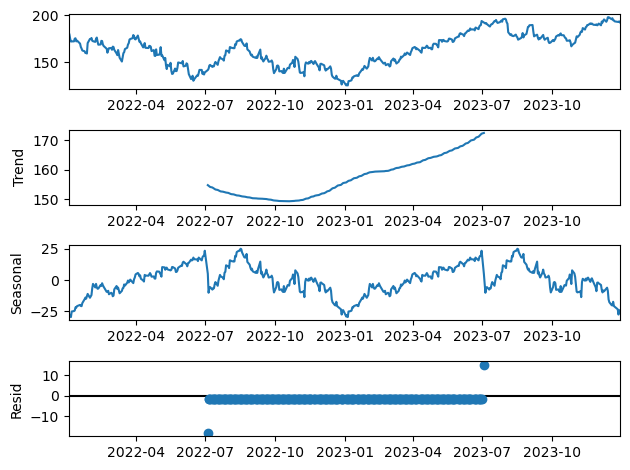

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Download stock data
ticker = "AAPL"
stock_data = yf.download(ticker, start="2022-01-01", end="2023-12-31")
close_prices = stock_data['Close']

"""
Amplitude and Frequency:

The amplitude of the seasonality shows the extent of the fluctuation within each cycle. High amplitude means larger ups and downs, while low amplitude suggests more subtle changes.
The frequency is the period of repetition. For example, if seasonality is annual, it repeats every 12 months.

Seasonal patterns can often be attributed to external or cyclical factors. In finance, for instance:
Annual Patterns: Stock prices may rise at the end of the year (due to holiday spending or end-of-year tax considerations) and experience dips in certain months (e.g., "Sell in May and go away" pattern).
Quarterly Patterns: Companies report earnings quarterly, which can lead to regular fluctuations as investors react to earnings reports.
Monthly or Weekly Patterns: There might also be smaller, predictable patterns, like increased activity on certain days of the week, known as the "day-of-the-week effect."

Ideally, residuals should be centered around zero. Positive values in the residual plot indicate points 
where the observed value was above the sum of the trend and seasonal components, while negative values indicate points where the observed value was below.

Large spikes or drops in the residual plot represent outliers, which are points where the actual data value 
deviates significantly from what was expected based on the trend and seasonality.
"""
# Perform seasonal decomposition
decomposition = seasonal_decompose(close_prices, model='additive', period=250)  # Assuming daily data with a yearly period
decomposition.plot()
plt.show()


In [5]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(close_prices.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

"""
A stationary time series has a constant mean and variance over time. The Augmented Dickey-Fuller (ADF) test is commonly used to test for stationarity.
"""

if result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")


ADF Statistic: -1.585435761613031
p-value: 0.4909053678056816
The time series is not stationary.


In [11]:
# First-order differencing
close_prices_diff = close_prices.diff().dropna()

from statsmodels.tsa.arima.model import ARIMA

"""
Determine d (Differencing Order) First
The d parameter is often determined first because it’s essential for making the time series stationary, which is crucial for ARIMA models.

Visual Inspection: Plot your data and look for trends or seasonality. If there’s an obvious trend, you might need differencing.
Stationarity Test: Use the Augmented Dickey-Fuller (ADF) test to check if your series is stationary. If the p-value is above 0.05, your series is likely non-stationary, so you’ll need to apply differencing.
Start with d = 1: Apply differencing once and then test again with the ADF test. If it’s still not stationary, try differencing twice (d = 2). Most commonly, d is either 0, 1, or 2.
"""

# Define the ARIMA model
model = ARIMA(close_prices, order=(1, 1, 1))  # p=1, d=1, q=1 for simplicity
arima_result = model.fit()

# Summary of the model
print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                  501
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1236.188
Date:                Tue, 12 Nov 2024   AIC                           2480.376
Time:                        19:33:13   BIC                           2497.243
Sample:                             0   HQIC                          2486.994
                                - 501                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        169.4484     12.250     13.832      0.000     145.438     193.459
ar.L1          0.9878      0.008    118.553      0.000       0.971       1.004
ma.L1          0.0185      0.042      0.442      0.6

/Users/tarundamodaran/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tarundamodaran/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tarundamodaran/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


10-day Forecast:
 501    192.234537
502    191.956942
503    191.682728
504    191.411856
505    191.144283
506    190.879970
507    190.618878
508    190.360966
509    190.106196
510    189.854529
Name: predicted_mean, dtype: float64


/Users/tarundamodaran/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


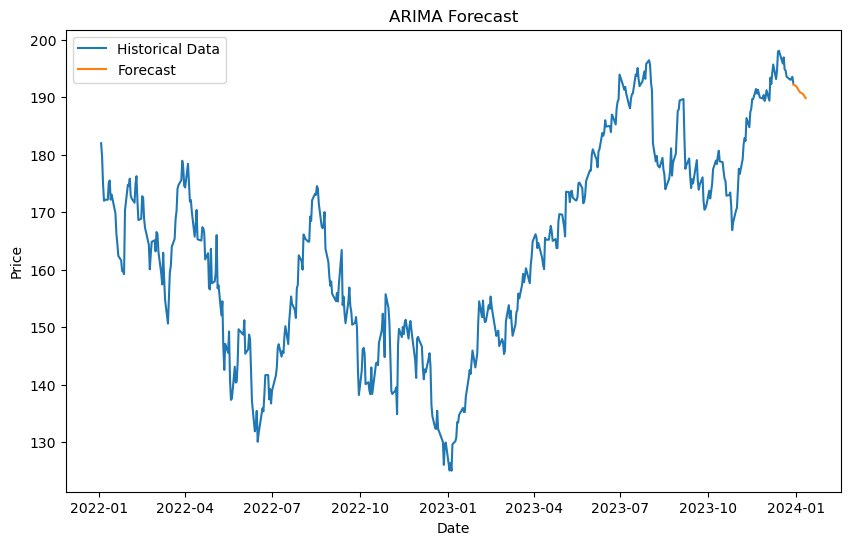

In [12]:
# Forecast the next 10 days
forecast = arima_result.forecast(steps=10)
print("10-day Forecast:\n", forecast)

# Plot forecast
plt.figure(figsize=(10, 6))
plt.plot(close_prices, label='Historical Data')
plt.plot(pd.date_range(close_prices.index[-1], periods=10, freq='B'), forecast, label='Forecast')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("ARIMA Forecast")
plt.legend()
plt.show()


In [13]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices.values.reshape(-1, 1))

# Prepare the data for LSTM (using a 60-day window)
def create_dataset(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_dataset(scaled_data, window_size)

# Reshape data for LSTM input
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [17]:
%pip install optree
%pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))  # Output layer

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=10, batch_size=32)


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ImportError: To use Keras, you need to have `optree` installed. Install it via `pip install optree`